In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import powerlaw
import seaborn as sns
import social_influence_algorithms
import xgboost as xgb
from scipy.stats import kstest

sns.set(rc={"figure.figsize": (15, 12)})
sns.set_style("darkgrid")
sns.set_palette("dark")

The [dataset](http://snap.stanford.edu/data/soc-sign-bitcoin-otc.html) is a who-trusts-whom network of people using Bitcoin on a platform called Bitcoin OTC. 

In [4]:
btc_trust_df = pd.read_csv("downloads/soc-sign-bitcoinotc.csv.gz")
btc_trust_df = btc_trust_df.rename(columns={"6": "SOURCE", "2": "TARGET", "4": "RATING", "1289241911.72836": "TIME"})

Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. I will assume if one user trusts another user, then they will be influenced by them, and this influence will be proportional to the trust rating.  

In [5]:
(btc_trust_df["RATING"] >= 0).value_counts(normalize=True).rename(index={True: "Positive", False: "Negative"})

Positive    0.89989
Negative    0.10011
Name: RATING, dtype: float64

Since a small proportion (10%) of trust ratings are negative, I will drop them, and otherwise prepare the data for use in the linear threshold model.

In [6]:
btc_trust_df = btc_trust_df.query("RATING >= 0")
btc_trust_df = btc_trust_df.drop(columns=["TIME"])
btc_trust_df[["RATING"]] /= 10
btc_trust_df = btc_trust_df.rename(columns={"RATING": "WEIGHT"})

nodes = np.unique(pd.concat([btc_trust_df["SOURCE"], btc_trust_df["TARGET"]]))
edges = list(btc_trust_df[["TARGET", "SOURCE", "WEIGHT"]].itertuples(index=False))

D = nx.DiGraph()
D.add_nodes_from(nodes)
D.add_weighted_edges_from(edges)

Let's have a look at the degree distribution.

<AxesSubplot:title={'center':'$\\bf{Log-Log\\hspace{1}Plot}$'}, xlabel='Degree k', ylabel='Proportion of Nodes with Degree k'>

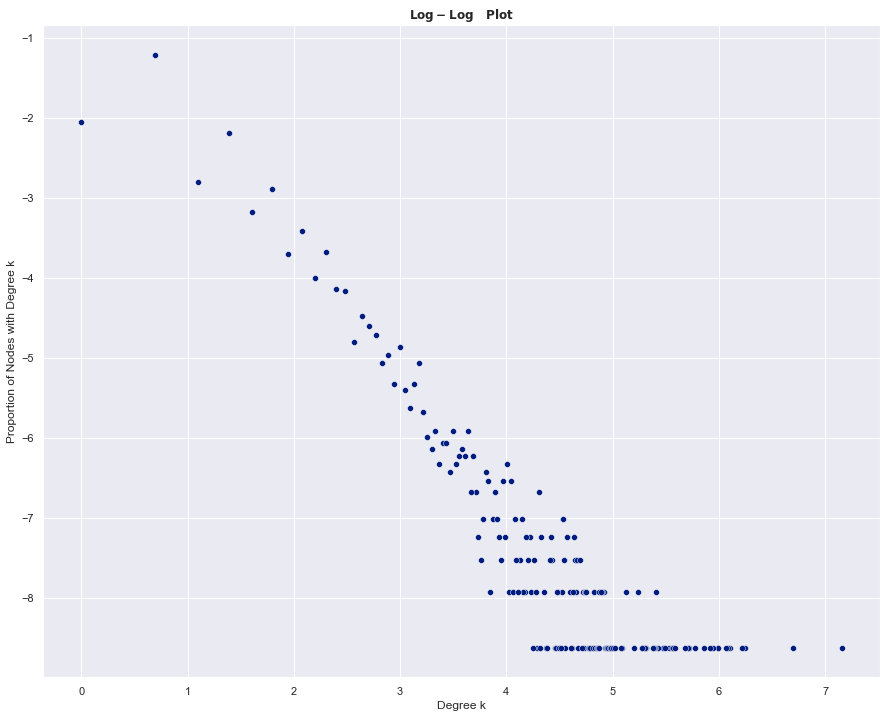

In [133]:
df2 = pd.DataFrame(D.degree)
df2 = df2.rename(columns={0: "node_number", 1: "num_neighbors"})
df2 = df2.value_counts("num_neighbors").to_frame()
df2[0] /= df2[0].sum()

fig, ax = plt.subplots()
ax.set_title(r"$\bf{" + "Log-Log" + "\hspace{1}" + "Plot" + "}$")
ax.set_xlabel("Degree k")
ax.set_ylabel("Proportion of Nodes with Degree k")
sns.scatterplot(x=np.log(df2.index), y=np.log(df2[0]))

The relationship between degree and the number of nodes with that degree looks like it follows a powerlaw. This is common in social networks.

I'm going to use mle to fit a powerlaw p(X=x) = constant * x ^ (-alpha) to the data.

In [103]:
fit = powerlaw.Fit(pd.DataFrame(D.degree)[1], discrete=True)

print("alpha: " + str(fit.power_law.alpha))
print("standard error: " + str(fit.power_law.sigma))

Calculating best minimal value for power law fit
alpha: 2.0173998206534005
standard error: 0.025808701193856164


likelihood ratio: 451.2309616956591
p: 3.465498924822223e-13


Text(0, 0.5, 'P(X > k)')

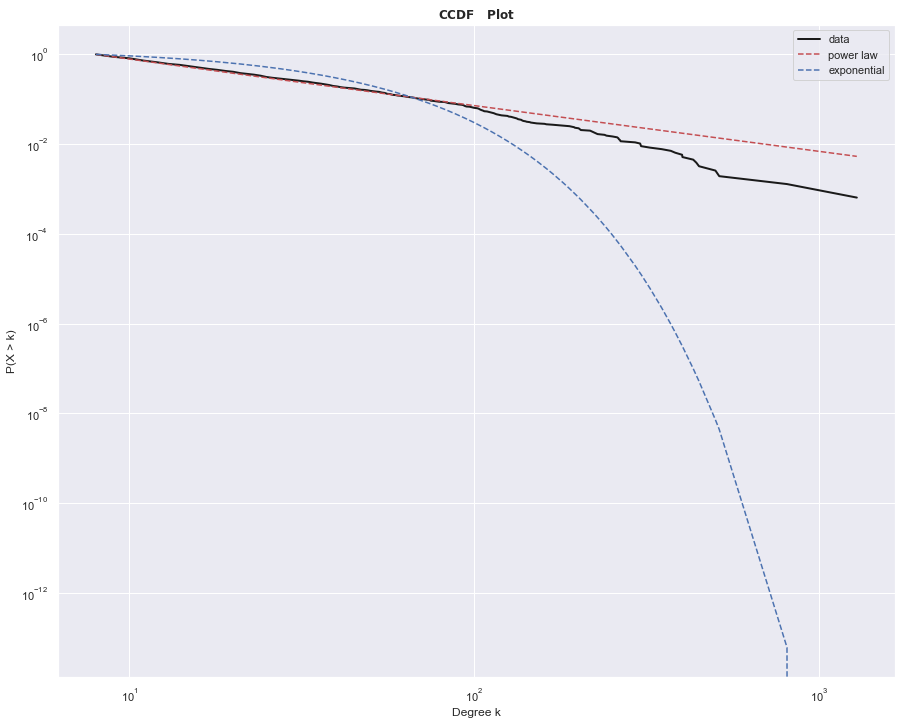

In [149]:
R, p = fit.distribution_compare("power_law", "exponential") 
print("likelihood ratio: " + str(R))
print("p: " + str(p))

fig2 = fit.plot_ccdf(color="k", linewidth=2)
fit.power_law.plot_ccdf(color="r", linestyle="--", ax=fig2)
fit.exponential.plot_ccdf(color="b", linestyle="--", ax=fig2)
fig2.legend(["data", "power law", "exponential"])


fig2.set_title(r"$\bf{" + "CCDF" + "\hspace{1}" + "Plot" + "}$")
fig2.set_xlabel("Degree k")
fig2.set_ylabel("P(X > k)")

While the powerlaw distribution is a much better fit for the data than exponential (the likelihood ratio is significant at the 0.05 significance level), neither are perfect. 

Since a person is a limited in the number of people they could potentially interact with, and thus in the number of users they could influence, there could be a gradual bounding effect on the scaling of the power law. The above figure appears to affirm this hypothesis, as p decays faster than the powerlaw fit. Lets compare the powerlaw with the truncated powerlaw, which reflects this bounding. 

likelihood ratio: -18.443983012123496
p: 1.2511581770624502e-09


Assuming nested distributions


<AxesSubplot:title={'center':'$\\bf{CCDF\\hspace{1}Plot}$'}, xlabel='degree k', ylabel='P(X > k)'>

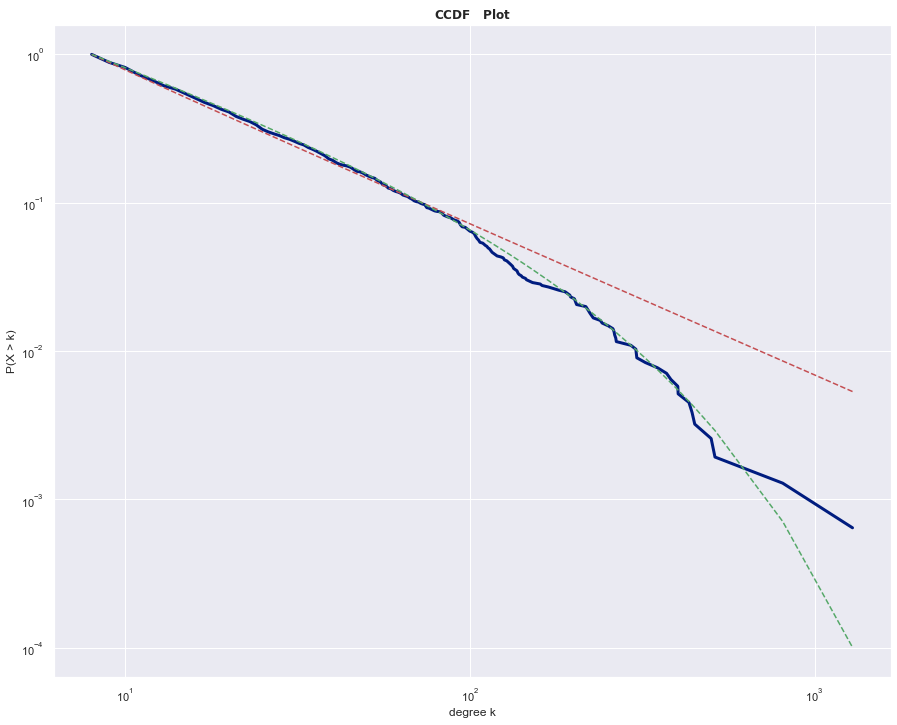

In [148]:
R, p = fit.distribution_compare("power_law", "truncated_power_law") 
print("likelihood ratio: " + str(R))
print("p: " + str(p))

fig2 = fit.plot_ccdf(linewidth=3)
fig2.set_title(r"$\bf{" + "CCDF" + "\hspace{1}" + "Plot" + "}$")
fig2.set_xlabel("degree k")
fig2.set_ylabel("P(X > k)")
fit.power_law.plot_ccdf(color="r", linestyle="--", ax=fig2)
fit.truncated_power_law.plot_ccdf(color="g", linestyle="--", ax=fig2)

The truncated powerlaw fits our data much better than the power law. This is indicated by the likelihood ratio which is significant at 0.05 significance.

The truncated powerlaw model has a pdf of p(X=x) = constant * x^(-alpha) * exp(-Lambda*x). Let's fit this with mle.

In [150]:
print("alpha: " + str(fit.truncated_power_law.alpha))
print("Lambda: " + str(fit.truncated_power_law.Lambda))
print("xmin: " + str(fit.truncated_power_law.xmin))

alpha: 1.8232179380763973
Lambda: 0.002611411352540347
xmin: 8.0


Lets see if this is an empiracally good fit by bootstrapping. This will take ages 

In [14]:
df4 = pd.DataFrame(D.degree)[1]
df5 = (df4 >= xmin).value_counts()
df5 /= df5.sum()
df5

n = df4.size

In [ ]:
theoretical_distribution = powerlaw.Truncated_Power_Law(xmin=xmin, parameters=[alpha, Lambda], discrete=True)
distance_between_observed_and_model = kstest(df4, cdf=fit.truncated_power_law.cdf)[0]

distances_between_sample_and_model = []
for _ in range(500):

    simulated_data = []
    for _ in range(n):
        if np.random.choice(df5.index, 1, p=df5)[0]:
            simulated_data.append(theoretical_distribution.generate_random(1, estimate_discrete=False)[0])
        else:
            simulated_data.append(np.random.choice(df4[df4 < 8.0]))
    sample_fit = powerlaw.Fit(simulated_data, discrete=True)
    distances_between_sample_and_model.append(kstest(simulated_data, cdf=sample_fit.truncated_power_law.cdf)[0])

In [ ]:
statistic_arr = (distances_between_sample_and_model > distance_between_observed_and_model)
print("p-value: " + str(np.sum(statistic_arr) / statistic_arr.size))

Since p > 0.10 we fail to reject the null hypothesis that our data is drawn from a truncated power law distribution with parameters alpha=1.8232179380763973, Lambda=0.002611411352540347, and xmin=8.0. The p-value can be interpreted as indicating that there is a 0.39 probability of sampling data as, or more, extreme than our data when drawing from the model distribution.

In [74]:
G = D.subgraph([i for i in range(300)])

Let's approximate the most influence subset of 10 users from G. My implementation of the LDAG algorithm is fairly slow as I used networkx as an interface for my data, this allowed for greater focus on analysis but clearly is not scalable.

In [33]:
social_influence_algorithms.seed_selection(G, 10)

initialization
main loop


[23, 25, 284, 81, 245, 223, 64, 135, 110, 8]

Let's check for any relationship between the influence a node has on its immediate successors and its total influence score. I'm going to take a node's weighted outdegree sum as a measure of its immediate influence.

In [155]:
influence_ratings = social_influence_algorithms.compute_influence(D.subgraph([i for i in range(300)]), theta=0.3)
df5 = pd.DataFrame(influence_ratings.items())
df5 = df5.rename(columns={1:"influence_score"})

sum_of_influence_weights = lambda u: sum([G.edges[e]["weight"] for e in G.out_edges(u)])
df5["weighted_outdegree_sum"] = [sum_of_influence_weights(u) for u in G.nodes]

array([[<AxesSubplot:title={'center':'influence_score'}>,
        <AxesSubplot:title={'center':'weighted_outdegree_sum'}>]],
      dtype=object)

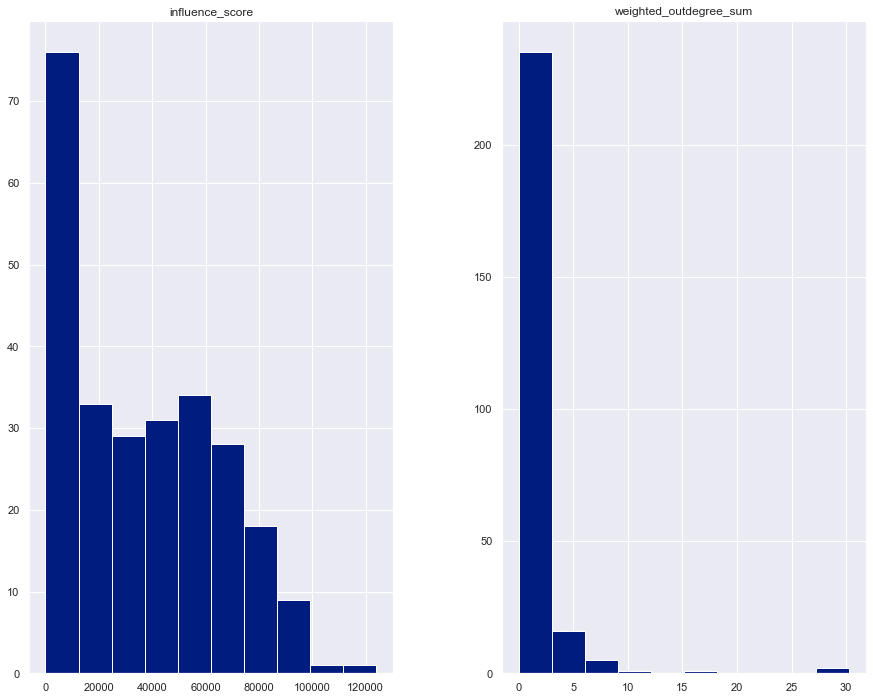

In [158]:
df5[["influence_score", "weighted_outdegree_sum"]].hist()

Both distributions have a heavy right tail skew, so the data won't be suitable for OLS regression analysis.

<AxesSubplot:xlabel='weighted_outdegree_sum', ylabel='influence_score'>

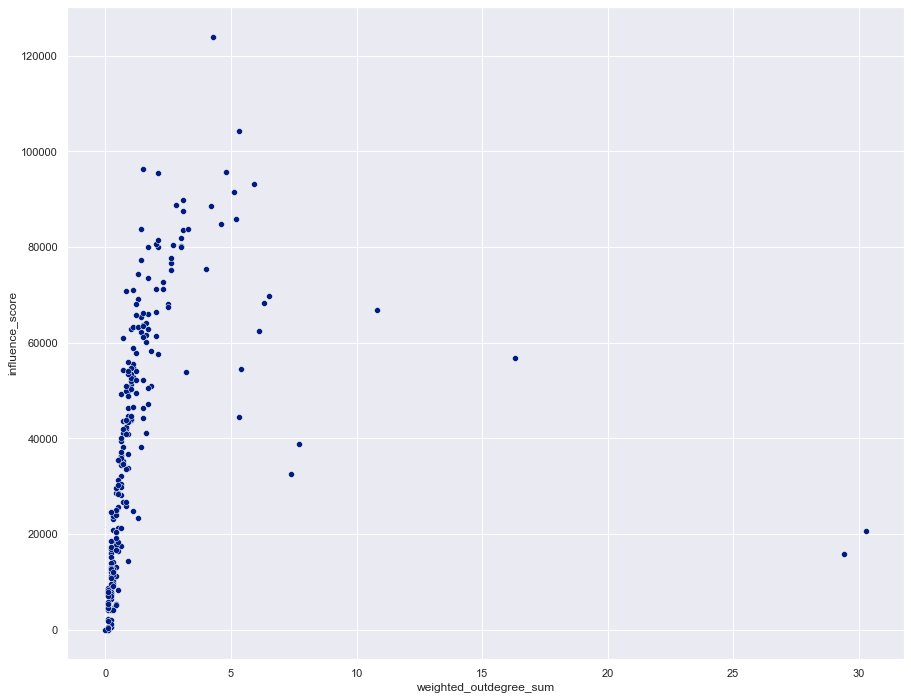

In [159]:
sns.scatterplot(data=df5, x="weighted_outdegree_sum", y="influence_score")

There appears to be a positive linear relationship between  and influence score. Degree appears to have a weaker relationship with influence score for higher influence scores. 

Let's fit an xgboost regression model to the data.

In [161]:
reg = xgb.XGBRegressor()

X = df5["weighted_outdegree_sum"]
y = df5["influence_score"]

X_train = X[:200]
y_train = y[:200]

X_test = X[200:]
y_test = y[200:]

reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [162]:
print("R-squared: " + str(reg.score(X_test, y_test)))

R-squared: 0.8452218713224996


The model has a high R^2: 84.5% of variance in a node's influence score is explained by its influence on its immediate successors by the model.